In [1]:
from dysh.spectra.spectrum import Spectrum
import numpy as np
from scipy.stats import norm
import astropy.units as u
import matplotlib.pyplot as plt
from dysh.fits.sdfitsload import SDFITSLoad
from dysh.fits.gbtfitsload import GBTFITSLoad
from dysh.spectra.scan import PSScan, GBTPSScan
import pandas
from copy import deepcopy
pandas.set_option('display.max_rows', 100)
from astropy.modeling.fitting import LevMarLSQFitter,LinearLSQFitter
from specutils import Spectrum1D, SpectrumList,SpectralRegion
from astropy.nddata import StdDevUncertainty
from specutils.fitting import fit_continuum
import matplotlib.pyplot as plt
from dysh.spectra import dcmeantsys,tsys_weight,average
from dysh.plot.specplot import SpectrumPlot
from astropy.io import fits
from astropy.table import Table
import pandas as pd
#%matplotlib notebook

-------------

# 1. GBTFITSLoad and position-switch calibration testing
change to use your specific `datadir`

In [ ]:
datadir = '/data/gbt'
#f = datadir + '/examples/misc/ngc5291.fits'
f = datadir + '/examples/onoff-L/data/TGBT21A_501_11.raw.vegas.fits'
#f = datadir + 'examples/nod-KFPA/data/TGBT22A_503_02.raw.vegas/TGBT22A_503_02.raw.vegas.A.fits'
#f = datadir + '/examples/mixed-fs-ps/data/AGBT16B_225_05/AGBT16B_225_05.raw.vegas/AGBT16B_225_05.raw.vegas.A.fits'
p = GBTFITSLoad(f)
p.info()

In [ ]:
p.summary()

In [ ]:
p.summary(verbose=True)

-----------------------------
# Get total power scan integrations and plot the time average 

In [ ]:
tps = p.gettp(scan=152,sig=True,cal=False,bintable=0,ifnum=0,plnum=1)
s=tps.timeaverage()
s.plot()
print(s.meta['TSYS'])

In [ ]:
tps.timeaverage(weights='tsys').plot()

## get another TP scan with different IF and Polarization and plot the 13th integration

In [ ]:
tps = p.gettp(scan=153,sig=True,cal=True,bintable=0,ifnum=1,plnum=1)
tps.total_power(12).plot()

## Try writing scans or records to FITS files and reading them back in


In [ ]:
scanlist = [152]

In [ ]:
p.write_scans("/tmp/scans.fits",overwrite=True,checksum=True,output_verify='fix',scans=scanlist)

In [ ]:
x1 = fits.open("/tmp/scans.fits")
x1.info()

In [ ]:
x1[1].header

In [ ]:
x1 = GBTFITSLoad("/tmp/scans.fits")
#x1._ptable[0]
x1._hdu.info()

In [ ]:
x1._hdu[1].header

In [ ]:
x1 = GBTFITSLoad("/tmp/foobar.fits")
#x1.nrows(0),x1._hdu[1].header
x1.summary()

In [ ]:
x1 = GBTFITSLoad("/tmp/onerows.fits")
x1.nrows(0),x1._hdu[1].header
x1.summary()

In [ ]:
spec4 = p.getspec(4)
sp = SpectrumPlot(spec4)
sp.plot()

## Get a position switch scan and calibrate it.
The default ifnum=0, plnum=0

In [ ]:
# eventually this will have calibrate=True as the default, so you don't need to call calibrate().
psscan = p.getps(152)

In [ ]:
psscan.calibrate()

### the raw calibrated numpy array

In [ ]:
psscan._calibrated

### A single integration of the calibrated Spectrum

In [ ]:
spec1 = psscan.calibrated(3)
sp = SpectrumPlot(spec1)
sp.plot(xaxis_unit="km/s")

### The average spectrum.  
You can plot with equal weights or $T_{sys}$ weighting (the default)
Compare this with GBTIDL `getps, 152`

In [ ]:
t=psscan.timeaverage(weights=None)
t.plot()
print(f"T_sys = {np.mean(psscan.tsys)}")

In [ ]:
t=psscan.timeaverage(weights='tsys').plot()

### Try a different polarization and IF and use the OFF scan number
GBTIDL `getps, 153, ifnum=1, plnum=1`

In [ ]:
psscan = p.getps(152,plnum=1,ifnum=1)
psscan.calibrate()

In [ ]:
psscan.timeaverage().plot()
print(f"T_sys = {np.mean(psscan.tsys)}")

### mixed FS and PS


In [ ]:
f = datadir + '/examples/mixed-fs-ps/data/AGBT16B_225_05/AGBT16B_225_05.raw.vegas/AGBT16B_225_05.raw.vegas.A.fits'
p = GBTFITSLoad(f)
p.info()
p.summary()

In [ ]:
p.gettp(6,sig=True,cal=False,ifnum=1,plnum=1)#.timeaverage().plot()


--------------------------------

# SubbeamNOD KPFA Data 

In [2]:
datadir = "/data/gbt/"
f = datadir + 'examples/subbeamnod-Ka/data/TRCO_230413_Ka.raw.vegas/TRCO_230413_Ka.raw.vegas.A.fits'
pnod = GBTFITSLoad(f)
pnod.info()

Filename: /data/gbt/examples/subbeamnod-Ka/data/TRCO_230413_Ka.raw.vegas/TRCO_230413_Ka.raw.vegas.A.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      12   ()      
  1  SINGLE DISH    1 BinTableHDU    245   5280R x 74C   ['32A', '1D', '22A', '1D', '1D', '1D', '1024E', '16A', '6A', '8A', '1D', '1D', '1D', '4A', '1D', '4A', '1D', '1I', '32A', '32A', '1J', '32A', '16A', '1E', '8A', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '8A', '1D', '1D', '12A', '1I', '1I', '1D', '1D', '1I', '1A', '1I', '1I', '16A', '16A', '1J', '1J', '22A', '1D', '1D', '1I', '1A', '1D', '1E', '1D', '1D', '1D', '1D', '1D', '1A', '1A', '8A', '1E', '1E', '16A', '1I', '1I', '1I']   


S  480
C  240
I  240
P  120
F  120
SR  46
46
TPSCAN nrows = 46
# scanrows 46, # calrows ON 46  # calrows OFF 46
S  480
C  240
I  240
P  120
F  120
SR  47
47
TPSCAN nrows = 47
# scanrows 47, # calrows ON 47  # calrows OFF 47


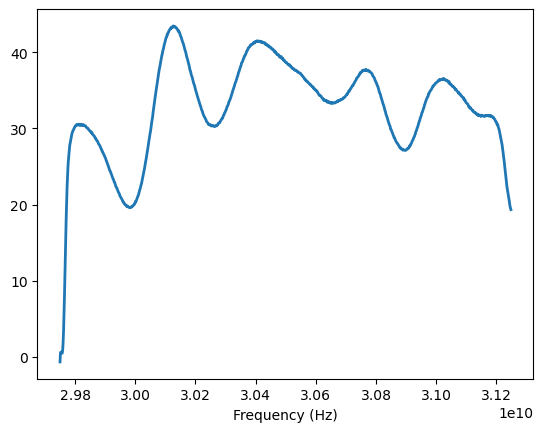

In [28]:
ifnum=0
plnum=0
fdnum=1
scan=46
tsys = {43:92.62,46:91.72}
bintable=0
weights='equal'
tpon  = pnod.gettp(scan,sig=True,cal=False,bintable=bintable,fdnum=fdnum,plnum=plnum,ifnum=ifnum,subref=-1)
tpoff = pnod.gettp(scan,sig=True,cal=False,bintable=bintable,fdnum=fdnum,plnum=plnum,ifnum=ifnum,subref=1)
on  =  tpon.timeaverage(weights=weights)
off = tpoff.timeaverage(weights=weights)
idl=tsys[scan]*(on-off)/off
idl.plot()

In [29]:
tpp=pnod.gettp(scan,sig=True,cal=False,bintable=bintable,fdnum=fdnum,plnum=plnum,ifnum=ifnum)
tpp.timeaverage(weights=weights).meta['TSYS']
np.mean(tpp.tsys)

S  480
C  240
I  240
P  120
F  120
120
TPSCAN nrows = 120
# scanrows 120, # calrows ON 120  # calrows OFF 120


91.09067474728589

In [30]:
s=pnod.getnod_ka(scan=scan,ifnum=ifnum,fdnum=fdnum,weights=weights)

S  480
C  240
I  240
P  120
F  120
SR  46
46
TPSCAN nrows = 46
# scanrows 46, # calrows ON 46  # calrows OFF 46
S  480
C  240
I  240
P  120
F  120
SR  47
47
TPSCAN nrows = 47
# scanrows 47, # calrows ON 47  # calrows OFF 47
Tsys(ON) = 111.63286970607624, Tsys(OFF) = 82.47435181946841, meanTsys = 97.05361076277232


(<Quantity 34.55849491>, 6.931331727845184, <Quantity -0.70420668>, <Quantity 45.97344765>)
[1.05815101 1.05815101 1.05815101 ... 1.05815101 1.05815101 1.05815101]
(<Quantity 1.05815101>, 2.1599919653272043e-16, <Quantity 1.05815101>, <Quantity 1.05815101>)
1.0581510113690833


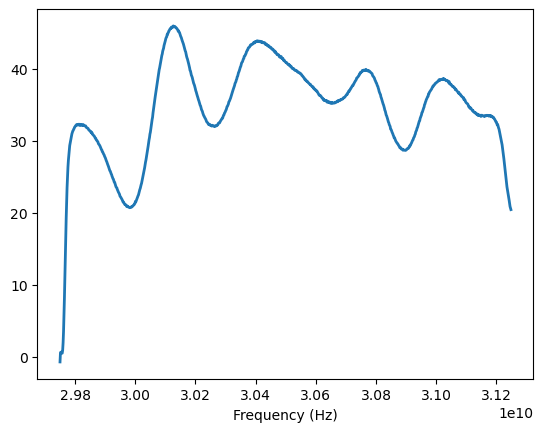

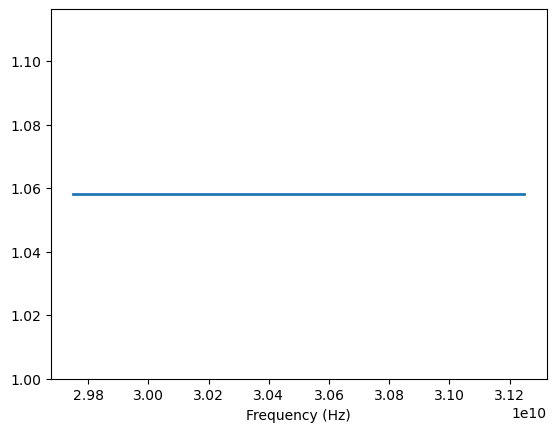

In [31]:
print(s.stats())
s.plot()
diff=s/idl
diff.plot()
print(diff.data)
print(diff.stats())
print(s.meta['TSYS']/tsys[scan])

-----
# Debugging from here down.